# Model evaluation: GRU (multitasking)

---

## Table of Contents

1. [Imports](#imports)
2. [Model loading](#model-loading)
3. [Data loading and tokenization](#data-loading-and-tokenization)
4. [Evaluation](#evaluation)
5. [Report](#report)

# Imports

In [1]:
import torch
import torch.nn as nn
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
MAX_NUM_WORDS = 20000
MAX_SEQ_LENGTH = 256

# Model loading

In [3]:
class MultiTaskGRU(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_labels_sentiment, num_labels_emotion):
        super(MultiTaskGRU, self).__init__()
        self.relu = nn.ReLU()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc_sentiment = nn.Linear(hidden_dim * 2, num_labels_sentiment)
        self.fc_emotion = nn.Linear(hidden_dim * 2, num_labels_emotion)
    
    def forward(self, input_ids_sent, input_ids_emot):
        embedded_sent = self.embedding(input_ids_sent)
        embedded_emot = self.embedding(input_ids_emot)

        gru_out_sent, _ = self.gru(embedded_sent)
        gru_out_emot, _ = self.gru(embedded_emot)

        pooled_sent = torch.mean(gru_out_sent, dim=1)
        pooled_emot = torch.mean(gru_out_emot, dim=1)

        dropped_sent = self.dropout(pooled_sent)
        dropped_emot = self.dropout(pooled_emot)

        out_sentiment = self.fc_sentiment(self.relu(dropped_sent))
        out_emotion = self.fc_emotion(self.relu(dropped_emot))

        return out_sentiment, out_emotion

In [4]:
device = 'cuda'

model = MultiTaskGRU(vocab_size=MAX_NUM_WORDS, embed_dim=256, hidden_dim=256, num_labels_sentiment=3, num_labels_emotion=6)
model.load_state_dict(torch.load('./GRU_multitask_model/gru_multitask_model.pth', map_location=device))
model.to(device)

C:\Users\Olga\AppData\Local\Temp\ipykernel_6548\2770308623.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./GRU_multitask_model/gru_mu

MultiTaskGRU(
  (relu): ReLU()
  (embedding): Embedding(20000, 256)
  (gru): GRU(256, 256, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_sentiment): Linear(in_features=512, out_features=3, bias=True)
  (fc_emotion): Linear(in_features=512, out_features=6, bias=True)
)

# Data loading and tokenization

In [5]:
base_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '..'))

train_file_sentiment = os.path.join(base_dir, 'train_sentiment.csv')
test_file_sentiment = os.path.join(base_dir, 'test_sentiment.csv')

train_data_sentiment = pd.read_csv(train_file_sentiment)
test_data_sentiment = pd.read_csv(test_file_sentiment)

train_file_emotion = os.path.join(base_dir, 'train_emotion.csv')
test_file_emotion = os.path.join(base_dir, 'test_emotion.csv')

train_data_emotion = pd.read_csv(train_file_emotion)
test_data_emotion = pd.read_csv(test_file_emotion)

In [6]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data_sentiment['text'].tolist() + train_data_emotion['text'].tolist())

In [7]:
class MultiTaskDataset(Dataset):
    def __init__(self, X_sent, y_sent, X_emot, y_emot):
        self.X_sent = torch.tensor(X_sent, dtype=torch.long)
        self.y_sent = torch.tensor(y_sent, dtype=torch.long)
        self.X_emot = torch.tensor(X_emot, dtype=torch.long)
        self.y_emot = torch.tensor(y_emot, dtype=torch.long)

    def __len__(self):
        return min(len(self.y_sent), len(self.y_emot))

    def __getitem__(self, idx):
        return {
            'input_ids_sent': self.X_sent[idx],
            'label_sent': self.y_sent[idx],
            'input_ids_emot': self.X_emot[idx],
            'label_emot': self.y_emot[idx]
        }

In [8]:
def encode_texts(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post', truncating='post')

In [9]:
X_test_sentiment = encode_texts(test_data_sentiment['text'])
y_test_sentiment = test_data_sentiment['label'].values

In [10]:
X_test_emotion = encode_texts(test_data_emotion['text'])
y_test_emotion = test_data_emotion['label'].values

In [11]:
test_dataset = MultiTaskDataset(X_test_sentiment, y_test_sentiment, X_test_emotion, y_test_emotion)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Evaluation

In [12]:
def evaluate(task_name, model, dataloader, class_names):
    all_preds, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            if task_name == "sentiment":
                input_ids = batch['input_ids_sent'].to(device)
                labels = batch['label_sent'].to(device)
                logits, _ = model(input_ids, input_ids)
                preds = torch.argmax(logits, dim=1)

            else:
                input_ids = batch['input_ids_emot'].to(device)
                labels = batch['label_emot'].to(device)
                _, logits = model(input_ids, input_ids)
                preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"Classification Report ({task_name}):")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    cm = confusion_matrix(all_labels, all_preds)
    cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    labels_fmt = np.array([["{0:.2f}%".format(val) for val in row] for row in cm_percent])

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_percent, annot=labels_fmt, fmt="", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predykcja")
    plt.ylabel("Rzeczywista klasa")
    plt.tight_layout()
    plt.savefig(f'cf_mat_gru_multi__{task_name}.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    f1_scores = [report[label]['f1-score'] for label in class_names]
    plt.figure(figsize=(5, 2.5))
    bars = plt.bar(class_names, f1_scores, color=['red', 'blue', 'green'] if task_name == "sentiment" else ['gray', 'green', 'pink', 'red', 'yellow', 'blue'])
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.09, f"{yval:.2f}", ha='center')
    plt.ylim(0, 1)
    plt.ylabel("F1-score")
    plt.xlabel('Klasa')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.savefig(f"f1_bar_gru_multi__{task_name}.png", dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

# Report

Classification Report (sentiment):
              precision    recall  f1-score   support

   Negatywny       0.54      0.77      0.63      3372
   Neutralny       0.68      0.57      0.62      6278
   Pozytywny       0.75      0.69      0.72      5056

    accuracy                           0.65     14706
   macro avg       0.65      0.67      0.66     14706
weighted avg       0.67      0.65      0.66     14706



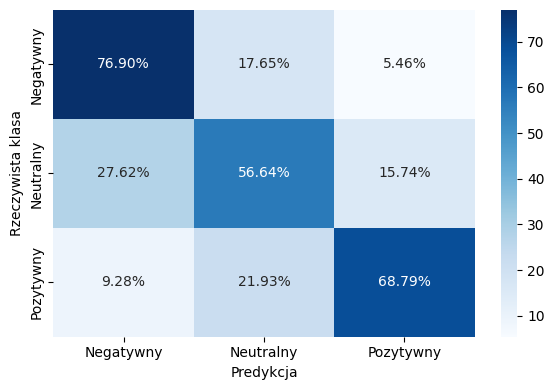

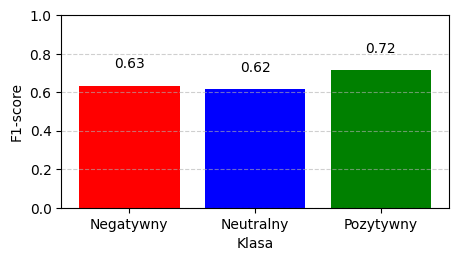

In [13]:
sentiment_classes = ['Negatywny', 'Neutralny', 'Pozytywny']
emotion_classes = ['Smutek', 'Radość', 'Miłość', 'Złość', 'Strach', 'Zaskoczenie']

evaluate("sentiment", model, test_loader, sentiment_classes)

Classification Report (emotion):
              precision    recall  f1-score   support

      Smutek       0.95      0.96      0.96      2500
      Radość       0.99      0.91      0.95      2500
      Miłość       0.93      0.99      0.96      2500
       Złość       0.98      0.89      0.93      2500
      Strach       0.92      0.90      0.91      2500
 Zaskoczenie       0.90      1.00      0.95      2206

    accuracy                           0.94     14706
   macro avg       0.94      0.94      0.94     14706
weighted avg       0.94      0.94      0.94     14706



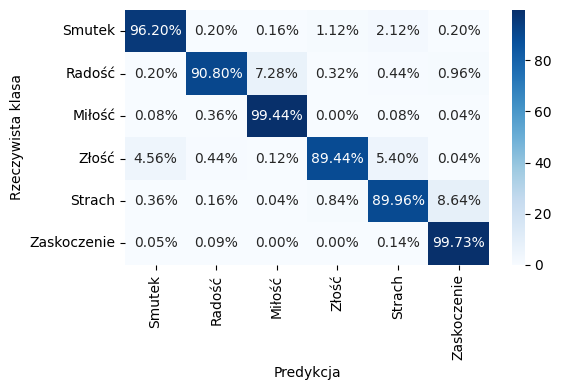

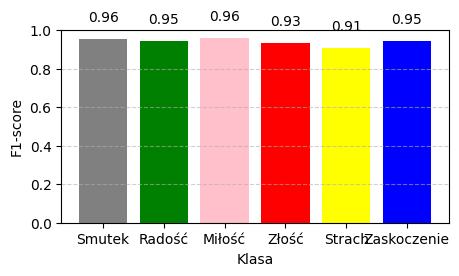

In [14]:
evaluate("emotion", model, test_loader, emotion_classes)